In [30]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from pathlib import Path
import pickle
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, r2_score, confusion_matrix
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import tensorflow as tf
from tensorflow.keras import Sequential, Input
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from tensorflow.keras.models import load_model
from tensorflow.python.keras.layers.kernelized import RandomFourierFeatures

import time

# Load data

In [48]:
data_dir = "data/classification/dr3"
def load_data(data_dir):
    list_5d = []
    list_6d = []
    for file in sorted(os.listdir(data_dir)):
        if "apg" in file:
            continue
        df = pd.read_csv(os.path.join(data_dir, file), index_col=0)
        if "5d" in file:
            list_5d.append(df)
        else:
            list_6d.append(df)
            
    df_5d = pd.concat(list_5d, axis=0, ignore_index=True)
    df_6d = pd.concat(list_6d, axis=0, ignore_index=True)
    return df_5d, df_6d

In [49]:
df_5d, df_6d = load_data(data_dir)

df_6d["class_6d"] = df_6d["class"]
df_6d["gm_p_high_6d"] = df_6d["gm_p_high"]
df = pd.merge(df_5d, df_6d[["Host", "class_6d", "gm_p_high_6d"]], on="Host")

# Helping functions

In [50]:
def encode_for_nn(y_test):
    depth = tf.constant(3)
    y_test = tf.one_hot(indices=y_test, depth=depth)
    
    return y_test

In [51]:
def cnn_scale(x_test):
    sc = StandardScaler()
    x_test = sc.fit_transform(x_test)
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
    
    return x_test

# Classification

### Load model

In [52]:
model = load_model("saved_models/ANN/ANN_model_30", compile=False)


Two checkpoint references resolved to different objects (<tensorflow.python.keras.saving.saved_model.load.RandomFourierFeatures object at 0x7f1e7e923970> and <tensorflow.python.keras.layers.core.Dense object at 0x7f1e7e923ca0>).

Two checkpoint references resolved to different objects (<tensorflow.python.keras.layers.core.Dense object at 0x7f1e7e923ca0> and <tensorflow.python.keras.layers.core.Dense object at 0x7f1e7e92c610>).

Two checkpoint references resolved to different objects (<tensorflow.python.keras.layers.core.Dense object at 0x7f1e7e92c610> and <tensorflow.python.keras.layers.core.Dense object at 0x7f1e7e92cd90>).


In [53]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss="categorical_crossentropy", metrics=['categorical_accuracy'])

### Specify test set size

In [54]:
test_size = 50000
x_test = df_6d[["target_density", "densities_max", "densities_min", "densities_mean", "gm_cov_high", "gm_mean_high"]][:test_size]
y_test = df_6d["class_6d"][:test_size]

### Predict star density group

In [55]:
preds = np.argmax(model.predict(x_test), axis=-1)
accuracy_score(y_test, preds), accuracy_score(y_test, df_5d["class"][:test_size])

(0.9465, 0.91648)

### Compare with 6D, 5D and 5D predicted values

In [56]:
def draw_triple_bar(bar1, bar2, bar3, bar1_label, bar2_label, bar3_label, classes, graph_name):
    pairs = 3
    ind = np.arange(pairs)
    plt.figure(figsize=(10,5), facecolor="w")
    width = 0.3       

    # Plotting
    plt.bar(ind, bar1, width, label=bar1_label, color=["g"])
    plt.bar(ind + width, bar2, width, label=bar2_label, color=["b"])
    plt.bar(ind + width*2, bar3, width, label=bar3_label, color=["y"])

    plt.xlabel('Class group')
    plt.ylabel('Number of stars')
    plt.xticks(ind + width / 2, classes)

    # Finding the best position for legends and putting it
    plt.legend(loc='best')
    plt.savefig(f"report_images/class_full_comparison.png")

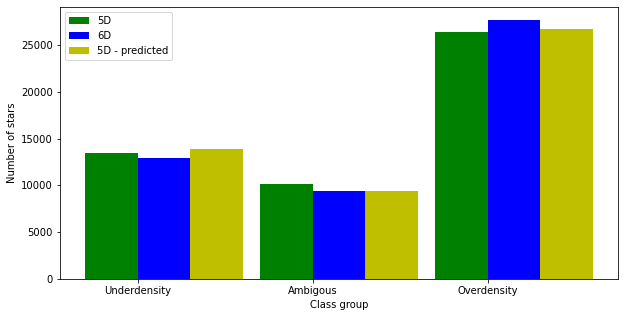

In [57]:
bar1 = df_5d["class"][:test_size].value_counts().sort_index().values
bar2 = df_6d["class"][:test_size].value_counts().sort_index().values
bar3 = np.unique(preds, return_counts=True)[1]
bar1_label = "5D"
bar2_label = "6D"
bar3_label = "5D - predicted"
classes = ['Underdensity', 'Ambigous', 'Overdensity']
graph_name = "prediction/6D comparison"
draw_triple_bar(bar1, bar2, bar3, bar1_label, bar2_label, bar3_label, classes, graph_name)

# Regression

In [58]:
def draw_reg(x, y, graph_name):
    fig = plt.figure(figsize=(7, 5), facecolor="w")
    plt.scatter(x, y)
    plt.xlabel("5D")
    plt.ylabel("Ground truth")
    plt.savefig(f"report_images/{graph_name}.png")
    #plt.close()

In [59]:
def draw_reg_comp(x1, y1, x2, y2, graph_name):
    fig = plt.figure(figsize=(7, 5), facecolor="w")
    plt.scatter(x2, y2, label="5D", c="g", alpha=0.3)
    plt.scatter(x1, y1, label="5D-predicted")
    
    plt.xlabel("5D")
    plt.ylabel("Ground truth")
    plt.legend(loc='best')
    plt.savefig(f"report_images/{graph_name}.png")
    #plt.close()

### Load model

In [60]:
model = load_model("saved_models/ANN_reg/ANN_model_13", compile=False)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss="mse")

In [61]:
x_test = df_6d[["target_density", "densities_max", "densities_min", "densities_mean", "gm_cov_high", "gm_mean_high"]][:test_size]
y_test = df_6d["gm_p_high"][:test_size]

In [62]:
preds = model.predict(x_test)
r2_score(y_test, preds), r2_score(y_test, df_5d["gm_p_high"][:test_size])

(0.9693223202910841, 0.9488441585634214)

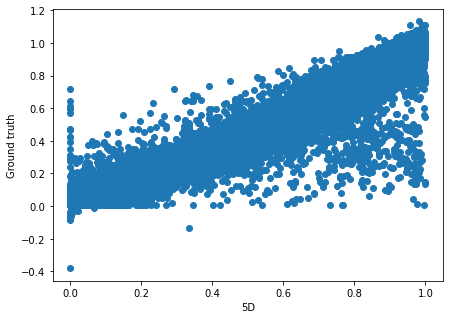

In [63]:
draw_reg(y_test, preds, "best_regressor")

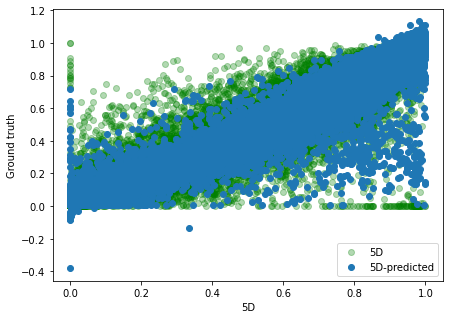

In [64]:
draw_reg_comp(y_test, preds, y_test, df_5d["gm_p_high"][:test_size], "reg_prediction_5d_comparison")